In [58]:
import pandas as pd  # Импорты
import numpy as np
import sklearn as sk
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [7]:
our_csv = pd.read_csv("data/S05-hw-dataset.csv")

In [14]:
print("Первые строки датасета: \n", our_csv.head())
print("\nИнформация о столбцах и типах: ")
print(our_csv.info())
print("\nБазовые описательные статистики для числовых признаков: \n",our_csv.describe())
print("\nРаспределение целевого признака: \n",our_csv.value_counts(normalize=True))

# Заметим, что в датасете 3000 объектов, каждый из которых имеет 17 признаков
# Сильных аномалий нету, разве что -3000 в checking_balance, но в принципе это допустимо (допустим, долг)
# Распределение классов примерно сбалансированно 

Первые строки датасета: 
    client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229       

In [16]:
X = our_csv.drop(columns=['client_id', 'default'])
y = our_csv['default']

In [21]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y);

In [25]:
dumb_clsfr = sk.dummy.DummyClassifier(strategy="most_frequent")
dumb_clsfr.fit(X_train, y_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


In [47]:
print(dumb_clsfr.score(X_test, y_test)) #accuracy на тестовой выборке
print(roc_auc_score(y_test, dumb_clsfr.predict_proba(X_test)[:, 1])) #roc_auc на тестовой выборке

0.5893333333333334
0.5


In [35]:
pipe = sk.pipeline.Pipeline([
    ("scaler", sk.preprocessing.StandardScaler()),
    ("logreg", sk.linear_model.LogisticRegression(max_iter=1000))
])

In [43]:
print(pipe.set_params(logreg__C=0.01).fit(X_train, y_train).score(X_test, y_test))
print(pipe.set_params(logreg__C=0.1).fit(X_train, y_train).score(X_test, y_test))
print(pipe.set_params(logreg__C=1).fit(X_train, y_train).score(X_test, y_test))
print(pipe.set_params(logreg__C=10).fit(X_train, y_train).score(X_test, y_test))

0.7973333333333333
0.7973333333333333
0.7933333333333333
0.7933333333333333


In [49]:
the_best = pipe.set_params(logreg__C=0.01).fit(X_train, y_train)
print(the_best.score(X_test, y_test))
print(roc_auc_score(y_test, the_best.predict_proba(X_test)[:, 1])) 

0.7973333333333333
0.8642754304519011


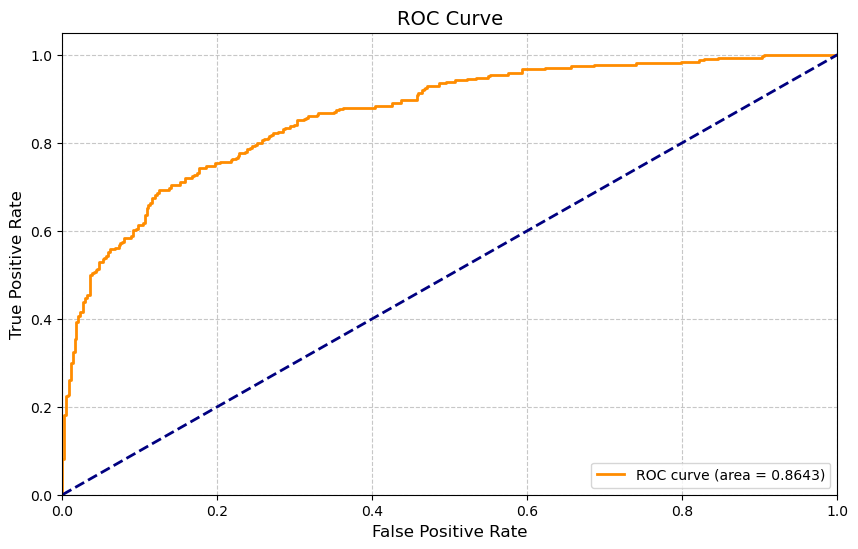

In [63]:
y_prob = the_best.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, y_prob)

roc_auc = sk.metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
results = pd.DataFrame({
    'Модель': ['DummyClassifier (Baseline)', 'LogisticRegression (C=10.0)'],
    'Accuracy': [dumb_clsfr.score(X_test, y_test), the_best.score(X_test, y_test)],
    'ROC-AUC': [roc_auc_score(y_test, dumb_clsfr.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, the_best.predict_proba(X_test)[:, 1])]
})

display(results.style.highlight_max(axis=0, subset=results.columns[1:]))

,Модель,Accuracy,ROC-AUC
0,DummyClassifier (Baseline),0.589333,0.500000
1,LogisticRegression (C=10.0),0.797333,0.864275


In [67]:
#Бейзлайн-модель (DummyClassifier) показала ожидаемо слабые результаты с ROC-AUC около 0.5 (уровень случайного угадывания) и точностью 58.9%
#Логистическая регрессия продемонстрировала значительное улучшение качества: при оптимальном значении C=0.01 ROC-AUC вырос до 0.864,
#а accuracy увеличилась до 0.797. Это свидетельствует о том, что модель действительно извлекает полезные закономерности из признаков.